In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from IPython.display import display, Markdown, Latex
import sys
import seaborn as sns

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sys.path.append("/n/home12/khou/holystore/")
import paper_utils
import scanpy as sc

In [2]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
URL_SUPP_TABLE = "https://www.dropbox.com/s/qojbzu5zln33j7f/supp_tables.xlsx?dl=1"

In [3]:
df_gs = pd.read_csv("01_score_cell/gs_file/human.gs", sep="\t")

trait_list = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
    "UKB_460K.body_BMIz",
    "UKB_460K.body_HEIGHTz",
]

In [4]:
df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

dict_trait_code = {
    row["Trait_Identifier"]: row["Code"] for _, row in df_trait_info.iterrows()
}

dict_dataset_code = {
    "zeisel_2015": "Zeisel & Muñoz-Manchado et al. (Mouse)",
    "habib_2016": "Habib & Li et al. (Mouse)",
    "zeisel_2018": "Zeisel et al. (Mouse)",
    "yao_2021": "Yao et al. (Mouse)",
    "habib_2017": "Habib, Avraham-Davidi, & Basu et al. (Human)",
    "zhong_2020": "Zhong et al. (Human fetal brain)",
    "ayhan_2021": "Ayhan et al. (Human adult brain with epilepsy)",
}


dataset_list = list(dict_dataset_code.keys())

In [5]:
stats_list = ["ctrl_zscore", "ctrl_pval", "tstats"]
dict_df_stats = {stats: dict() for stats in stats_list}

spatial_cols = [
    "spatial_dorsal",
    "spatial_ventral",
    "spatial_proximal",
    "spatial_distal",
    "spatial_deep",
    "spatial_superficial",
]
for dataset in dataset_list:
    for stats in stats_list:
        dict_df_stats[stats][dataset] = []
        for trait in trait_list:
            df_tmp = pd.read_csv(
                join("01_score_cell/regression_file", dataset, trait + ".csv"),
                index_col=0,
            )
            df_tmp = df_tmp[
                [col for col in df_tmp.columns if col.endswith(stats)]
            ].rename(columns=lambda col: col[: -len(stats) - 1])
            dict_df_stats[stats][dataset].append(df_tmp)
        dict_df_stats[stats][dataset] = pd.concat(dict_df_stats[stats][dataset])

        dict_df_stats[stats][dataset] = dict_df_stats[stats][dataset][spatial_cols]

# One heatmap per dataset

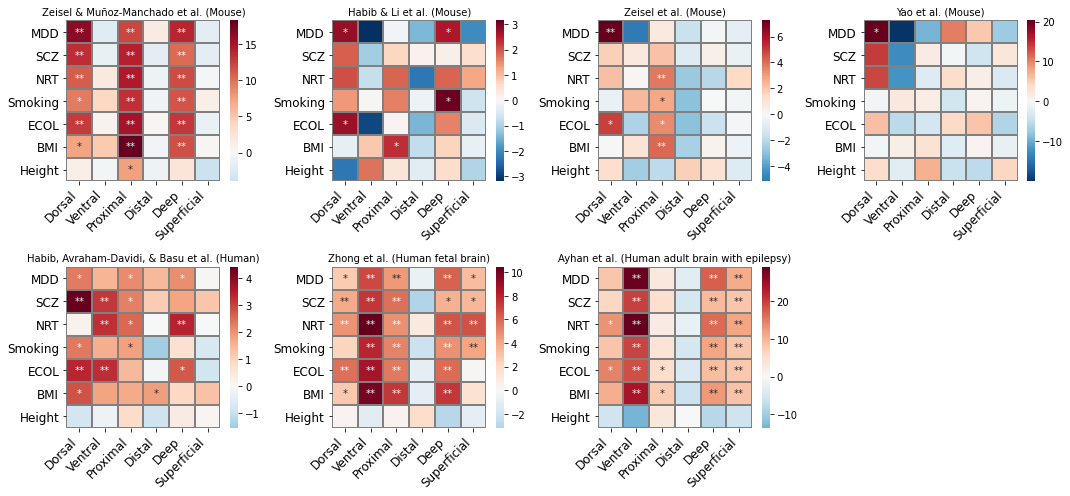

In [6]:
def pval2str(p_):
    if p_ > 0.05:
        return ""
    elif p_ > 0.005:
        return "*"
    else:
        return "**"


fig, ax = plt.subplots(figsize=(15, 7), nrows=2, ncols=4)
ax = ax.flatten()
for i, dataset in enumerate(dataset_list):
    df_plot = dict_df_stats["tstats"][dataset]
    df_plot_annot = dict_df_stats["ctrl_pval"][dataset].applymap(pval2str)
    h = sns.heatmap(
        df_plot.rename(index=dict_trait_code, columns=lambda x: x[8:].capitalize()),
        annot=df_plot_annot,
        linewidths=0.2,
        linecolor="gray",
        fmt="s",
        cmap="RdBu_r",
        center=0,
        ax=ax[i],
        annot_kws={"size": 10},
    )
    h.set_xticklabels(h.get_xticklabels(), rotation=45, fontsize=12, ha="right")
    h.set_yticklabels(h.get_yticklabels(), fontsize=12)

    ax[i].set_title(dict_dataset_code[dataset], fontsize=10)
plt.tight_layout()

ax.flatten()[-1].set_axis_off()

plt.savefig("results/spatial_regression_heatmap_per_dataset.pdf", bbox_inches="tight")

# One heatmap per spatial direction

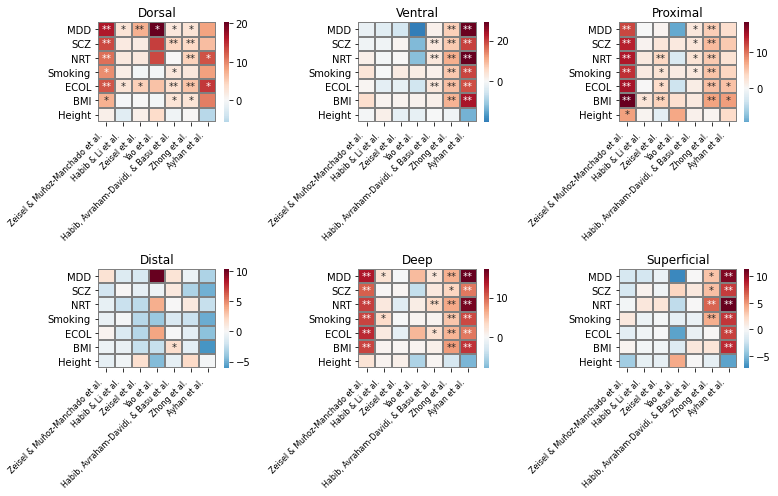

In [7]:
dataset_list = list(dict_dataset_code.keys())

fig, ax = plt.subplots(figsize=(11, 7), nrows=2, ncols=3)
ax = ax.flatten()


for i_col, col in enumerate(spatial_cols):
    df_plot = pd.concat(
        [dict_df_stats["tstats"][dataset][col] for dataset in dataset_list], axis=1
    )
    df_plot.columns = dataset_list

    df_plot_annot = pd.concat(
        [dict_df_stats["ctrl_pval"][dataset][col] for dataset in dataset_list], axis=1
    )
    df_plot_annot.columns = dataset_list
    df_plot_annot = df_plot_annot.applymap(pval2str)

    h = sns.heatmap(
        df_plot.rename(
            index=dict_trait_code, columns=lambda x: dict_dataset_code[x].split("(")[0]
        ),
        annot=df_plot_annot,
        linewidths=0.2,
        linecolor="gray",
        fmt="s",
        cmap="RdBu_r",
        center=0,
        ax=ax[i_col],
        annot_kws={"size": 10},
    )
    h.set_xticklabels(h.get_xticklabels(), rotation=45, fontsize=8, ha="right")
    ax[i_col].set_title(col.split("_")[1].capitalize(), fontsize=12)

plt.tight_layout()
plt.savefig("results/spatial_regression_heatmap_per_spatial.pdf", bbox_inches="tight")

# Summarized replication status
- Color by average t-statistics
- Signifiance by fisher p-values
- Averaged across MDD, SCZ, NRT, Smoking, Education College.

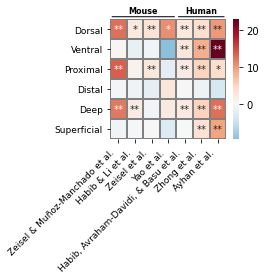

In [8]:
def annotation_line(
    ax,
    xy1,
    xy2,
    text,
    linecolor="black",
    linewidth=1,
    fontsize=8,
    text_rotation=0,
    text_offset_x=0,
    text_offset_y=0,
    text_color="black",
):

    ax.annotate(
        "",
        xy=xy1,
        xytext=xy2,
        xycoords="axes fraction",
        textcoords="axes fraction",
        annotation_clip=False,
        arrowprops={"arrowstyle": "-", "color": linecolor, "linewidth": linewidth},
    )
    xcenter = (xy1[0] + xy2[0]) / 2
    ycenter = (xy1[1] + xy2[1]) / 2

    ax.annotate(
        text,
        xy=(xcenter + text_offset_x, ycenter + text_offset_y),
        xycoords="axes fraction",
        textcoords="axes fraction",
        ha="center",
        va="center",
        fontsize=fontsize,
        annotation_clip=False,
        rotation=text_rotation,
        weight="bold",
        color=text_color,
    )


from scipy.stats import combine_pvalues

average_trait_list = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
]

# Color by average t-statistics
df_plot = pd.concat(
    [
        dict_df_stats["tstats"][dataset].loc[average_trait_list].mean(axis=0)
        for dataset in dataset_list
    ],
    axis=1,
)
df_plot.columns = dataset_list


df_plot_annot = pd.DataFrame(
    [
        [
            combine_pvalues(
                dict_df_stats["ctrl_pval"][dataset].loc[average_trait_list][col]
            )[1]
            for col in spatial_cols
        ]
        for dataset in dataset_list
    ],
    index=dataset_list,
    columns=spatial_cols,
).T

df_plot_annot = df_plot_annot.applymap(pval2str)

fig, ax = plt.subplots(figsize=(2.6, 2.2))

h = sns.heatmap(
    df_plot.rename(
        index=lambda x: x.split("_")[1].capitalize(),
        columns=lambda x: dict_dataset_code[x].split("(")[0],
    ),
    annot=df_plot_annot,
    linewidths=0.2,
    linecolor="gray",
    fmt="s",
    cmap="RdBu_r",
    center=0,
    ax=ax,
    annot_kws={"size": 10},
)
h.set_xticklabels(h.get_xticklabels(), rotation=45, fontsize=9, ha="right")
h.set_yticklabels(h.get_yticklabels(), fontsize=9)

annotation_line(ax, (0, 1.02), (4 / 7, 1.02), "Mouse", text_offset_y=0.05)
annotation_line(ax, (4 / 7, 1.02), (1, 1.02), "Human", text_offset_y=0.05)
plt.savefig("results/spatial_regression_replication_summary.pdf", bbox_inches="tight")

In [9]:
from scipy.stats import pearsonr
from toolz import interleave

In [10]:
processed_dir = "00_prepare_dataset/processed"

adata = sc.read_h5ad(join(processed_dir, "zeisel_2015.processed.h5ad"))
adata = adata[adata.obs["level2class"].isin(["CA1Pyr1", "CA1Pyr2"])]

# load scores
df_list = []
for spatial_col in spatial_cols:
    temp_df = pd.read_csv(
        join(
            "01_score_cell/score_file",
            "zeisel_2015",
            f"{spatial_col}.score.gz",
        ),
        sep="\t",
        index_col=0,
    )
    temp_df.columns = ["%s.%s" % (spatial_col, x) for x in temp_df.columns]
    df_list.append(temp_df)

df_spatial_score = pd.concat(df_list, axis=1)
df_spatial_score = df_spatial_score[
    [col for col in df_spatial_score if col.endswith(".norm_score")]
].rename(columns=lambda c: c[:-11])

for spatial_col in df_spatial_score.columns:
    adata.obs[spatial_col] = df_spatial_score[spatial_col].reindex(adata.obs.index)


for trait in trait_list:

    df_trait_score = pd.read_csv(
        join("01_score_cell/score_file/zeisel_2015", f"{trait}.score.gz"),
        sep="\t",
        index_col=0,
    )
    adata.obs[trait] = df_trait_score["norm_score"].reindex(adata.obs.index)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [11]:
dict_ys = dict()
for col in ["dorsal", "proximal", "ventral", "distal", "deep", "superficial"]:
    q = pd.qcut(adata.obs[f"spatial_{col}"], q=5)

    dict_ys[col] = {trait: [] for trait in trait_list}
    for interval in q.cat.categories:
        interval_cell_index = interval == q
        for trait in trait_list:
            dict_ys[col][trait].append(np.mean(adata.obs[trait][interval_cell_index]))

In [12]:
df_pval = dict_df_stats["ctrl_pval"]["zeisel_2015"].copy()
df_pval.columns.name = "Trait"
df_varexp = pd.DataFrame(index=df_pval.index, columns=df_pval.columns)


def style_font(x):
    str_x = f"{x:.2g}"
    if x < 0.005:
        return "\textbf{" + str_x + "}"
    else:
        return str_x


import statsmodels.api as sm

proximal_r2 = []
joint_r2 = []
for trait in df_varexp.index:
    for spatial_col in df_varexp.columns:
        rls = sm.OLS(adata.obs[trait], sm.add_constant(adata.obs[spatial_col])).fit()
        df_varexp.loc[trait, spatial_col] = rls.rsquared

df_pval = df_pval.rename(
    index=dict_trait_code, columns=lambda x: x[8:].capitalize()
).applymap(lambda x: style_font(x))

df_varexp = df_varexp.rename(
    index=dict_trait_code, columns=lambda x: x[8:].capitalize()
).applymap(lambda x: f"{x:.3f}")

df_pval.columns = [col + ".P" for col in df_pval.columns]
df_varexp.columns = [col + ".Var" for col in df_varexp.columns]

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [13]:
print(
    pd.concat([df_pval, df_varexp], axis=1)[
        list(interleave([df_pval, df_varexp]))
    ].to_latex(escape=False, column_format="|c|cc|cc|cc|cc|cc|cc|")
)

\begin{tabular}{|c|cc|cc|cc|cc|cc|cc|}
\toprule
{} &        Dorsal.P & Dorsal.Var & Ventral.P & Ventral.Var &      Proximal.P & Proximal.Var & Distal.P & Distal.Var &          Deep.P & Deep.Var & Superficial.P & Superficial.Var \\
\midrule
MDD     &  \textbf{0.001} &      0.245 &      0.75 &       0.006 &  \textbf{0.002} &        0.151 &     0.25 &      0.003 &  \textbf{0.001} &    0.189 &          0.82 &           0.004 \\
SCZ     &  \textbf{0.001} &      0.178 &      0.67 &       0.002 &  \textbf{0.001} &        0.194 &     0.81 &      0.004 &  \textbf{0.001} &    0.114 &          0.83 &           0.004 \\
NRT     &  \textbf{0.002} &      0.130 &      0.28 &       0.004 &  \textbf{0.001} &        0.205 &     0.65 &      0.001 &  \textbf{0.001} &    0.146 &          0.55 &           0.000 \\
Smoking &           0.009 &      0.099 &      0.13 &       0.017 &  \textbf{0.001} &        0.176 &     0.61 &      0.001 &  \textbf{0.001} &    0.139 &          0.27 &           0.002 \\
ECOL    

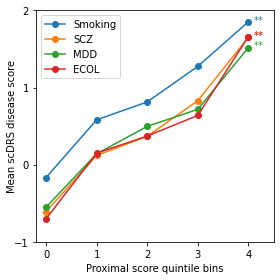

In [14]:
df_plot_annot = dict_df_stats["ctrl_pval"]["zeisel_2015"].applymap(pval2str)
color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(4, 4))
col = "proximal"

for i_trait, trait in enumerate(
    [
        "UKB_460K.cov_SMOKING_STATUS",
        "PASS_Schizophrenia_Pardinas2018",
        "PASS_MDD_Howard2019",
        "UKB_460K.cov_EDU_COLLEGE",
    ]
):
    label = dict_trait_code[trait]

    ax.plot(
        dict_ys[col][trait],
        "o-",
        label=label,
        color=color_list[i_trait],
    )
    ax.annotate(
        df_plot_annot.loc[trait, f"spatial_{col}"],
        xy=(4.1, dict_ys[col][trait][-1]),
        xycoords="data",
        xytext=(0, -1),
        textcoords="offset points",
        color=color_list[i_trait],
    )

    ax.set_xticks(np.arange(5))
    ax.set_xlim(-0.5, 4.8)

ax.set_xlabel(f"{col.capitalize()} score quintile bins")
ax.grid(False)

# fig.legend(
#     loc="upper left",
#     prop={"size": 7},
#     ncol=1,
#     bbox_to_anchor=(0.23, 0.92),
#     frameon=True,
#     handlelength=1.5,
# )
plt.legend()
ax.set_ylabel("Mean scDRS disease score", labelpad=-3)
# from matplotlib.ticker import FormatStrFormatter

# ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.xlim(-0.2, 4.5)
plt.ylim(-1, 2.0)
# plt.xticks(fontsize=8)
plt.yticks([-1, 0, 1, 2])
plt.tight_layout()
plt.savefig("results/disease_spatial_trend.svg")

In [15]:
adata

AnnData object with n_obs × n_vars = 827 × 14538
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes', 'leiden', 'spatial_dorsal', 'spatial_ventral', 'spatial_proximal', 'spatial_distal', 'spatial_deep', 'spatial_superficial', 'PASS_MDD_Howard2019', 'PASS_Schizophrenia_Pardinas2018', 'UKB_460K.mental_NEUROTICISM', 'UKB_460K.cov_SMOKING_STATUS', 'UKB_460K.cov_EDU_COLLEGE', 'UKB_460K.body_BMIz', 'UKB_460K.body_HEIGHTz'
    var: 'BackSPIN', 'n_cells'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [16]:
adata_ca1 = adata.copy()
sc.pp.filter_cells(adata_ca1, min_genes=0)
sc.pp.filter_genes(adata_ca1, min_cells=1)
sc.pp.normalize_total(adata_ca1, target_sum=1e4)
sc.pp.log1p(adata_ca1)

sc.pp.highly_variable_genes(adata_ca1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_ca1 = adata_ca1[:, adata_ca1.var.highly_variable]
sc.pp.scale(adata_ca1, max_value=10)
sc.tl.pca(adata_ca1, svd_solver="arpack")

sc.pp.neighbors(adata_ca1, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_ca1, n_components=2)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


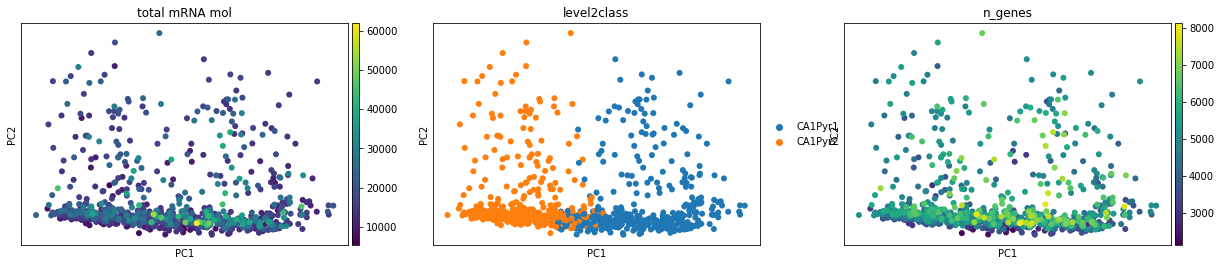

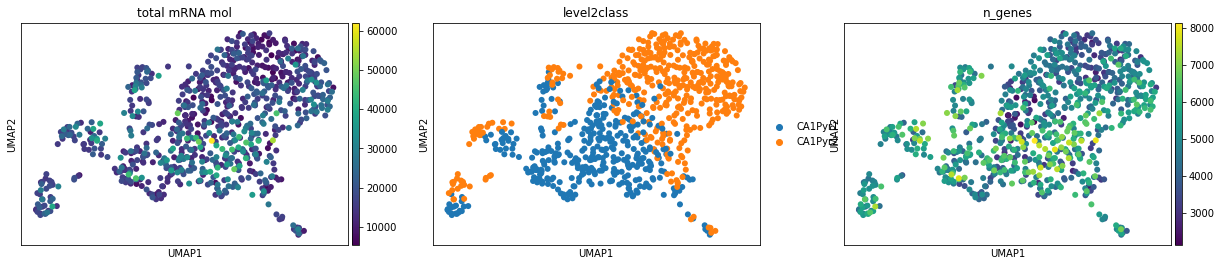

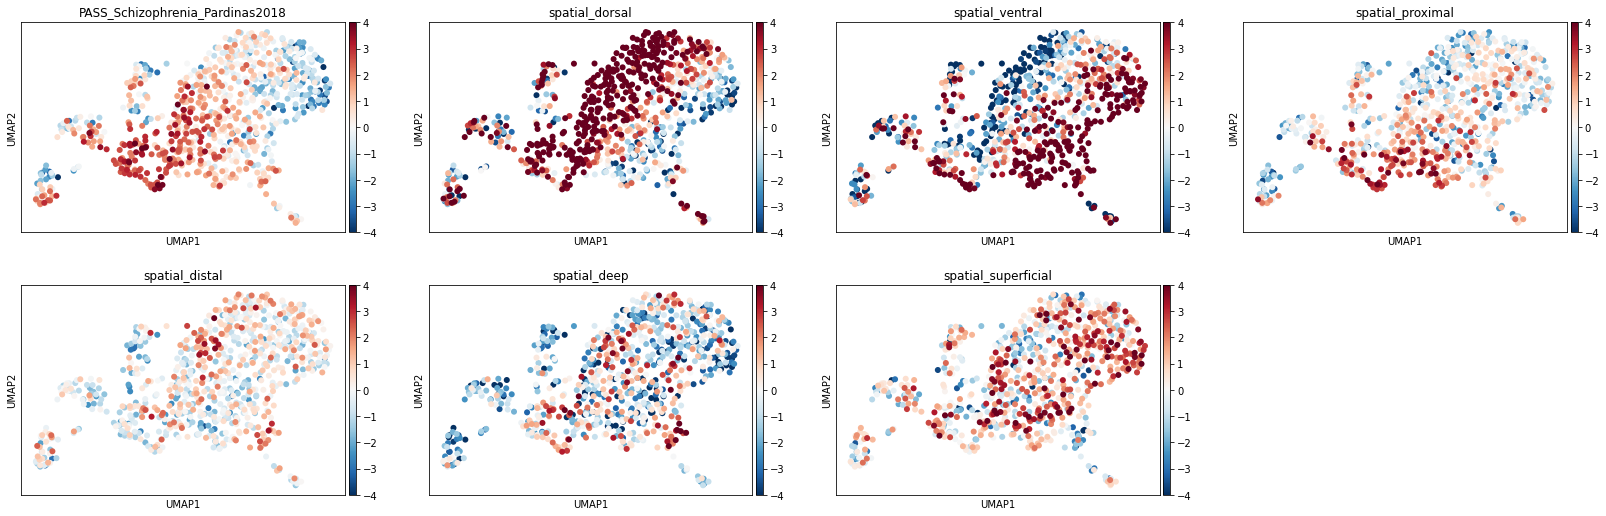

In [17]:
sc.pl.pca(
    adata_ca1,
    color=[
        "total mRNA mol",
        "level2class",
        "n_genes",
    ],
)

sc.pl.umap(
    adata_ca1,
    color=[
        "total mRNA mol",
        "level2class",
        "n_genes",
    ],
)

sc.pl.umap(
    adata_ca1,
    color=[
        "PASS_Schizophrenia_Pardinas2018",
        "spatial_dorsal",
        "spatial_ventral",
        "spatial_proximal",
        "spatial_distal",
        "spatial_deep",
        "spatial_superficial",
    ],
    cmap="RdBu_r",
    vmin=-4,
    vmax=4,
)

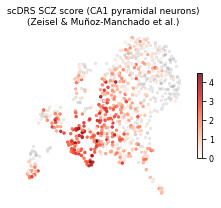

In [18]:
fig, ax = plt.subplots(figsize=(3.2, 3))
positive_index = adata_ca1.obs["PASS_Schizophrenia_Pardinas2018"] > 0
negative_index = adata_ca1.obs["PASS_Schizophrenia_Pardinas2018"] <= 0

plt.scatter(
    adata_ca1.obsm["X_umap"][negative_index, 0],
    adata_ca1.obsm["X_umap"][negative_index, 1],
    color="gray",
    vmin=0,
    vmax=4,
    s=6,
    alpha=0.15,
)

plt.scatter(
    adata_ca1.obsm["X_umap"][positive_index, 0],
    adata_ca1.obsm["X_umap"][positive_index, 1],
    c=adata_ca1.obs["PASS_Schizophrenia_Pardinas2018"][positive_index],
    cmap="Reds",
    vmin=0,
    vmax=4.5,
    s=6,
    alpha=0.8,
)

cbar = plt.colorbar(ticks=np.arange(5), shrink=0.5)
cbar.ax.tick_params(labelsize=8)


ax.grid(False)
ax.axis("off")
plt.xticks([])
plt.yticks([])
plt.title(
    "scDRS SCZ score (CA1 pyramidal neurons)\n(Zeisel & Muñoz-Manchado et al.)",
    fontsize=9,
)
plt.tight_layout()
plt.savefig("results/main_scz_umap.svg", bbox_inches="tight")

In [19]:
# For multiple traits

plot_trait_list = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
    "UKB_460K.body_HEIGHTz",
]

<ipython-input-20-73337f5e3153>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


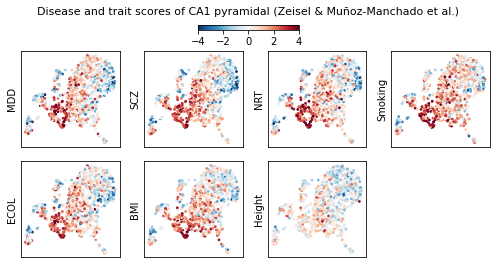

In [20]:
fig, ax = plt.subplots(figsize=(7, 3.5), nrows=2, ncols=4)
ax = ax.flatten()
for i, trait in enumerate(trait_list):

    scatter = ax[i].scatter(
        adata_ca1.obsm["X_umap"][:, 0],
        adata_ca1.obsm["X_umap"][:, 1],
        c=adata_ca1.obs[trait],
        cmap="RdBu_r",
        vmin=-4,
        vmax=4,
        s=3,
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel(dict_trait_code[trait], fontsize=10)
ax[-1].set_axis_off()
plt.suptitle(
    "Disease and trait scores of CA1 pyramidal (Zeisel & Muñoz-Manchado et al.)",
    fontsize=11,
    y=1.05,
)
cbar_ax = fig.add_axes([0.4, 0.96, 0.2, 0.02])
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(np.arange(-4, 5, 2))

plt.tight_layout()
plt.savefig("results/umap_all_traits.pdf", bbox_inches="tight")

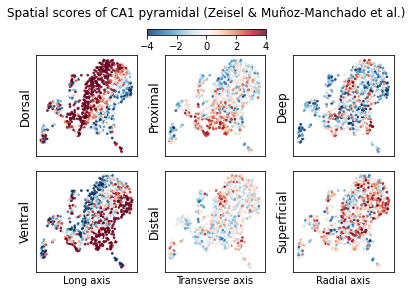

In [21]:
sc.tl.umap(adata_ca1, n_components=2)

fig, ax = plt.subplots(figsize=(5.5, 3.5), nrows=2, ncols=3)
ax = ax.flatten()
for i, col in enumerate(
    ["dorsal", "proximal", "deep", "ventral", "distal", "superficial"]
):
    scatter = ax.flatten()[i].scatter(
        adata_ca1.obsm["X_umap"][:, 0],
        adata_ca1.obsm["X_umap"][:, 1],
        c=adata_ca1.obs[f"spatial_{col}"],
        cmap="RdBu_r",
        vmin=-4,
        vmax=4,
        s=3,
        alpha=0.8,
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel(col.capitalize(), fontsize=12)
ax[3].set_xlabel("Long axis")
ax[4].set_xlabel("Transverse axis")
ax[5].set_xlabel("Radial axis")

plt.tight_layout()
plt.suptitle(
    f"Spatial scores of CA1 pyramidal (Zeisel & Muñoz-Manchado et al.)",
    y=1.15,
    fontsize=12,
)
cbar_ax = fig.add_axes([0.35, 1.04, 0.3, 0.02])
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(np.arange(-4, 5, 2))
# cbar_ax.set_xticklabels(np.arange(-4, 5))
plt.savefig(f"results/umap2d_spatial_score.pdf", bbox_inches="tight")

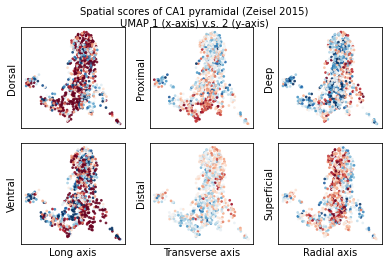

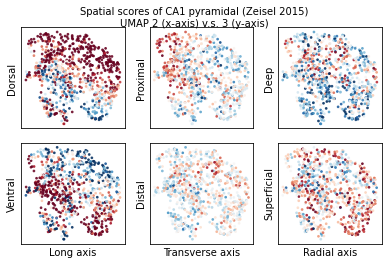

In [22]:
sc.tl.umap(adata_ca1, n_components=3)

for i_coord in [0, 1]:
    fig, ax = plt.subplots(figsize=(5.5, 3.5), nrows=2, ncols=3)
    ax = ax.flatten()
    for i, col in enumerate(
        ["dorsal", "proximal", "deep", "ventral", "distal", "superficial"]
    ):
        ax.flatten()[i].scatter(
            adata_ca1.obsm["X_umap"][:, i_coord],
            adata_ca1.obsm["X_umap"][:, i_coord + 1],
            c=adata_ca1.obs[f"spatial_{col}"],
            cmap="RdBu_r",
            vmin=-4,
            vmax=4,
            s=3,
            alpha=0.8,
        )
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel(col.capitalize(), fontsize=10)
    ax[3].set_xlabel("Long axis")
    ax[4].set_xlabel("Transverse axis")
    ax[5].set_xlabel("Radial axis")

    plt.tight_layout()
    plt.suptitle(
        f"Spatial scores of CA1 pyramidal (Zeisel 2015)\nUMAP {i_coord + 1} (x-axis) v.s. {i_coord + 2} (y-axis)",
        y=1.04,
        fontsize=10,
    )
    plt.savefig(f"results/umap_3d_{i_coord}_spatial_score.pdf", bbox_inches="tight")